In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from epitools import get_data
from scipy.stats import pearsonr

In [58]:
country = "chile"
geography_id = "region_id"
year = 2017

df_1 = get_data(
    country=country,
    aggregation=geography_id,
    election="first_round",
    method="nv",
    year=year
)

df_2 = get_data(
    country=country,
    aggregation=geography_id,
    election="first_round",
    method="nv_all",
    year=year
)

df_1[geography_id] = df_1[geography_id].astype(str)
df_2[geography_id] = df_2[geography_id].astype(str)

data = pd.merge(df_1, df_2, on=[geography_id, "year"])
if country == "France":
    data = data[~data["department_id"].str.contains("Z")]

for col in ["epi", "epi_between", "epi_within"]:
    data[f"{col}_x"] = (data[f"{col}_x"] - data[f"{col}_x"].mean()) / data[f"{col}_x"].std()
    data[f"{col}_y"] = (data[f"{col}_y"] - data[f"{col}_y"].mean()) / data[f"{col}_y"].std()

data = data.melt(id_vars=[geography_id, "year"])
data["type"] = data["variable"].str.replace("_x", "").str.replace("_y", "")
data["variable"] = data["variable"].str.replace("epi_", "").str.replace("within_", "").str.replace("between_", "")

data = data.pivot(index=[geography_id, "year", "type"], columns=["variable"], values="value").reset_index()
data.head()
data.shape

(48, 5)

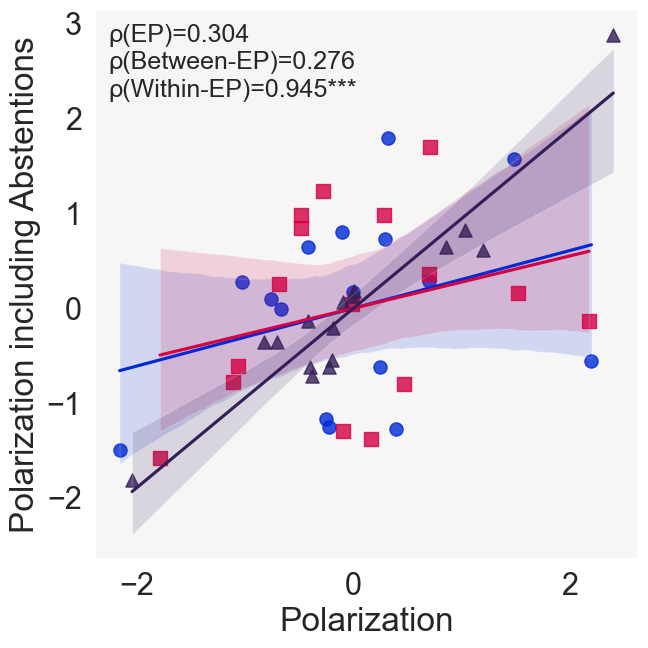

In [59]:
# 
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

fig, ax = plt.subplots(figsize=(7, 7))

for item in [
    (data[data["type"] == "epi"], "#0029D4", "o"),
    (data[data["type"] == "epi_between"], "#D40042", "s"),
    (data[data["type"] == "epi_within"], "#341E57", "^")
]:
    g = sns.regplot(
        x="x",  y="y", 
        # hue="type", 
        #hue_order=["epi", "epi_between", "epi_within"], 
        #markers=["o", "s", "^"], 
        marker=item[2],
        scatter_kws={"s": 90},
        # palette=["#0029D4", "#D40042", "#341E57"], 
        # legend=False,
        color=item[1],
        data=item[0], 
        ax=ax
        # height=7
    )

ax.set_xlabel("Polarization")
ax.set_ylabel("Polarization including Abstentions")
# ax.set_title(year, fontweight=700)

pos = 0.975
for i, dd in data.groupby("type"):
    corr, pvalue = pearsonr(dd["x"], dd["y"])
    def corrfunc(corr, pvalue, label):
        ax = plt.gca()
        note = ""
        if pvalue < 0.001:
            note = "***"
        elif pvalue < 0.05:
            note = "**"
        elif pvalue < 0.1:
            note = "*"

        return f"ρ({label})=" + "{:.3f}{}".format(corr, note)
    labels = {"epi": "EP", "epi_between": "Between-EP", "epi_within": "Within-EP"}
    val = corrfunc(corr, pvalue, labels[i])
    ax.text(0.025, pos, val, transform=ax.transAxes, va="top", fontsize=18)
    pos -= 0.05

fig.tight_layout()

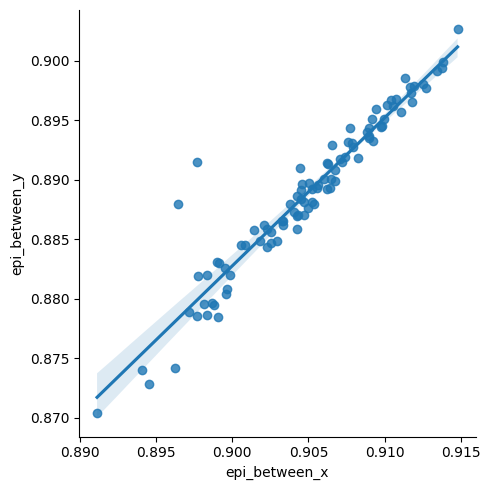

In [ ]:
sns.lmplot(x="epi_between_x", y="epi_between_y", data=data)

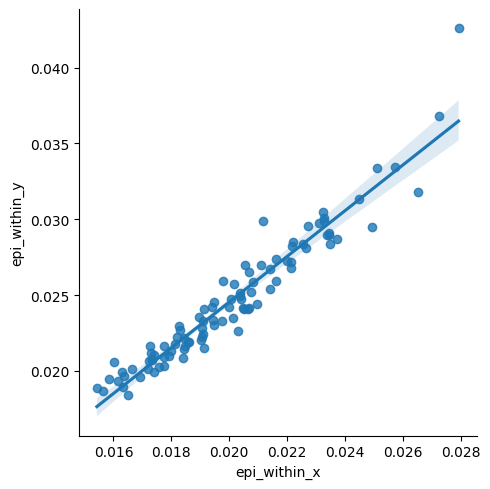

In [ ]:
sns.lmplot(x="epi_within_x", y="epi_within_y", data=data)